In [4]:
import re
import torch
import detector
import graphviz
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, tree, neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

LANGS = ['en', 'es', 'fr', 'de']

In [5]:
data = pd.read_csv('data/meteor_table_200k.csv', index_col=0)
data['src'] = data['src'].astype('category')
data['origin'] = data['origin'].astype('category')

In [6]:
data

,T0-T1_en,T1-T2_en,T2-T3_en,T0-T1_es,T1-T2_es,T2-T3_es,T0-T1_fr,T1-T2_fr,T2-T3_fr,T0-T1_de,T1-T2_de,T2-T3_de,src,origin,len
0,0.997685,0.997685,0.997685,0.996000,0.996000,0.996000,0.0,0.0,0.0,0.996000,0.996000,0.996000,fr,en,8.0
1,0.780859,0.999624,0.999624,0.766154,0.920940,0.999772,0.0,0.0,0.0,0.921592,0.999624,0.999624,fr,en,17.0
2,0.998542,0.998542,0.998542,0.999023,0.999023,0.999023,0.0,0.0,0.0,0.999023,0.999023,0.999023,fr,en,9.0
3,0.916972,0.999500,0.999500,0.979938,0.999914,0.999914,0.0,0.0,0.0,0.928079,0.999711,0.999711,fr,en,15.0
4,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.0,0.0,0.0,0.500000,0.500000,0.500000,fr,en,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.944348,0.999914,0.999914,0.999938,0.999938,0.999938,0.0,0.0,0.0,0.936389,0.999878,0.999878,fr,de,25.0
59996,0.999898,0.999898,0.999898,0.820015,0.999946,0.999946,0.0,0.0,0.0,0.710963,0.999878,0.999878,fr,de,24.0
59997,0.916322,0.999964,0.999964,0.680265,0.961292,0.999972,0.0,0.0,0.0,0.304878,0.725243,0.758027,fr,de,26.0
59998,0.897917,0.999938,0.999938,0.733006,0.995562,0.999968,0.0,0.0,0.0,0.785142,0.999946,0.999946,fr,de,31.0


## Utility functions

In [7]:
def plot_confusion_matrix(true_labels, prediction, column_labels): 
    cm_data = confusion_matrix(true_labels, prediction)
    df_cm = pd.DataFrame(cm_data, columns=column_labels, index = column_labels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

## Filter problematic rows and columns

In [8]:
def non_equal_row(row):
    non_src_langs = [lang for lang in LANGS if lang != row['src']]
    unique_values = set([row['T0-T1_'+lang] for lang in non_src_langs] + [row['T1-T2_'+lang] for lang in non_src_langs])
    return len(unique_values) > 1

filtered = data[(data.len > 9) & (data.apply(non_equal_row, axis=1))]
filtered = filtered.reset_index(drop=True)
filtered = filtered.drop(columns=['T2-T3_en', 'T2-T3_es', 'T2-T3_fr', 'T2-T3_de'])

In [9]:
filtered

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.780859,0.999624,0.766154,0.920940,0.0,0.0,0.921592,0.999624,fr,en,17.0
1,0.916972,0.999500,0.979938,0.999914,0.0,0.0,0.928079,0.999711,fr,en,15.0
2,0.963577,0.999964,0.837370,0.999977,0.0,0.0,0.887046,0.999968,fr,en,30.0
3,0.847187,0.890685,0.920659,0.999989,0.0,0.0,0.566432,0.810026,fr,en,46.0
4,0.581264,0.977101,0.957678,0.413759,0.0,0.0,0.700723,0.951147,fr,en,90.0
...,...,...,...,...,...,...,...,...,...,...,...
54499,0.944348,0.999914,0.999938,0.999938,0.0,0.0,0.936389,0.999878,fr,de,25.0
54500,0.999898,0.999898,0.820015,0.999946,0.0,0.0,0.710963,0.999878,fr,de,24.0
54501,0.916322,0.999964,0.680265,0.961292,0.0,0.0,0.304878,0.725243,fr,de,26.0
54502,0.897917,0.999938,0.733006,0.995562,0.0,0.0,0.785142,0.999946,fr,de,31.0


## Remove divergent rows

In [10]:
convergent = []
for lang in LANGS:
    convergent.append(filtered[(filtered['T0-T1_{}'.format(lang)] <= filtered['T1-T2_{}'.format(lang)]) & (filtered['origin'] == lang)])

filtered = pd.concat(convergent, axis=0)
filtered = filtered.reset_index(drop=True)
filtered

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.780859,0.999624,0.766154,0.920940,0.0,0.0,0.921592,0.999624,fr,en,17.0
1,0.916972,0.999500,0.979938,0.999914,0.0,0.0,0.928079,0.999711,fr,en,15.0
2,0.963577,0.999964,0.837370,0.999977,0.0,0.0,0.887046,0.999968,fr,en,30.0
3,0.847187,0.890685,0.920659,0.999989,0.0,0.0,0.566432,0.810026,fr,en,46.0
4,0.581264,0.977101,0.957678,0.413759,0.0,0.0,0.700723,0.951147,fr,en,90.0
...,...,...,...,...,...,...,...,...,...,...,...
49590,0.944348,0.999914,0.999938,0.999938,0.0,0.0,0.936389,0.999878,fr,de,25.0
49591,0.999898,0.999898,0.820015,0.999946,0.0,0.0,0.710963,0.999878,fr,de,24.0
49592,0.916322,0.999964,0.680265,0.961292,0.0,0.0,0.304878,0.725243,fr,de,26.0
49593,0.897917,0.999938,0.733006,0.995562,0.0,0.0,0.785142,0.999946,fr,de,31.0


## Generate Diffs Table

In [11]:
def translation_bias(src, lang, bias = -0.2):
    if src == 'en' and lang == 'de' or src == 'de' and lang == 'en' or src == 'es' and lang == 'fr' or src == 'fr' and lang == 'es':
        return bias
    return 0

diffs = []
for lang in LANGS:
    first_col = 'T0-T1_{}'.format(lang)
    second_col = 'T1-T2_{}'.format(lang)
    diffs.append(filtered[[first_col, second_col, 'src']].apply(lambda x: ((1 - (x[second_col] + translation_bias(x['src'], lang))) + (1 - (x[first_col] + translation_bias(x['src'], lang)))), axis=1))

diff_df = pd.concat(diffs + [filtered[['origin', 'src']]], axis=1)
diff_df.columns = ['en_diff', 'es_diff', 'fr_diff', 'de_diff','origin', 'src']

In [12]:
diff_df

,en_diff,es_diff,fr_diff,de_diff,origin,src
0,0.219516,0.712906,2.0,0.078784,en,fr
1,0.083528,0.420147,2.0,0.072210,en,fr
2,0.036460,0.562653,2.0,0.112986,en,fr
3,0.262128,0.479352,2.0,0.623542,en,fr
4,0.441635,1.028563,2.0,0.348130,en,fr
...,...,...,...,...,...,...
49590,0.055737,0.400125,2.0,0.063733,de,fr
49591,0.000204,0.580039,2.0,0.289159,de,fr
49592,0.083714,0.758443,2.0,0.969879,de,fr
49593,0.102146,0.671432,2.0,0.214912,de,fr


## A little bit of exploration

In [13]:
len(diff_df[(diff_df['en_diff'] < diff_df['es_diff']) & (diff_df['en_diff'] < diff_df['fr_diff']) & (diff_df['en_diff'] < diff_df['de_diff']) & (diff_df['origin'] == 'en')]) / len(diff_df[(diff_df['origin'] == 'en')])

0.4967653242762413

In [14]:
def convergence_ratio(df, l_cols, r_cols, origins):
    for lcol, rcol, orig in zip(l_cols, r_cols, origins):
        ratio = len(df[(df[lcol] <= df[rcol]) & (df['origin'] == orig)]) / len(df[(df['origin'] == orig)])
        print("Ratio for {} < {} and origin {}: {}".format(lcol, rcol, orig, ratio))

In [15]:
convergence_ratio(filtered, ['T0-T1_' + lang for lang in LANGS], ['T1-T2_' + lang for lang in LANGS], LANGS)

Ratio for T0-T1_en < T1-T2_en and origin en: 1.0
Ratio for T0-T1_es < T1-T2_es and origin es: 1.0
Ratio for T0-T1_fr < T1-T2_fr and origin fr: 1.0
Ratio for T0-T1_de < T1-T2_de and origin de: 1.0


In [16]:
convergence_ratio(filtered, ['T0-T1_en']*4, ['T1-T2_en']*4, LANGS)

Ratio for T0-T1_en < T1-T2_en and origin en: 1.0
Ratio for T0-T1_en < T1-T2_en and origin es: 0.9359821641850465
Ratio for T0-T1_en < T1-T2_en and origin fr: 0.9378029079159935
Ratio for T0-T1_en < T1-T2_en and origin de: 0.9469487388120423


In [17]:
convergence_ratio(filtered, ['T0-T1_es']*4, ['T1-T2_es']*4, LANGS)

Ratio for T0-T1_es < T1-T2_es and origin en: 0.9425036390101892
Ratio for T0-T1_es < T1-T2_es and origin es: 1.0
Ratio for T0-T1_es < T1-T2_es and origin fr: 0.9445880452342488
Ratio for T0-T1_es < T1-T2_es and origin de: 0.9530512611879577


In [18]:
convergence_ratio(filtered, ['T0-T1_fr']*4, ['T1-T2_fr']*4, LANGS)

Ratio for T0-T1_fr < T1-T2_fr and origin en: 0.9416141031861556
Ratio for T0-T1_fr < T1-T2_fr and origin es: 0.939007882793216
Ratio for T0-T1_fr < T1-T2_fr and origin fr: 1.0
Ratio for T0-T1_fr < T1-T2_fr and origin de: 0.9508543531326281


In [19]:
convergence_ratio(filtered, ['T0-T1_de']*4, ['T1-T2_de']*4, LANGS)

Ratio for T0-T1_de < T1-T2_de and origin en: 0.925764192139738
Ratio for T0-T1_de < T1-T2_de and origin es: 0.92475515566526
Ratio for T0-T1_de < T1-T2_de and origin fr: 0.92859450726979
Ratio for T0-T1_de < T1-T2_de and origin de: 1.0


## Normalize Data

In [20]:
def normalize_values(values):
    scaler = MinMaxScaler()
    return scaler.fit_transform(values)

norm_data = filtered.copy()

norm_data['len'] = normalize_values(norm_data['len'].values.reshape(-1, 1))
norm_data['src'] = normalize_values(norm_data['src'].cat.codes.values.reshape(-1, 1))
norm_data['origin'] = norm_data['origin'].cat.codes.values.reshape(-1, 1)

norm_data

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
0,0.780859,0.999624,0.766154,0.920940,0.0,0.0,0.921592,0.999624,1.0,1,0.032407
1,0.916972,0.999500,0.979938,0.999914,0.0,0.0,0.928079,0.999711,1.0,1,0.023148
2,0.963577,0.999964,0.837370,0.999977,0.0,0.0,0.887046,0.999968,1.0,1,0.092593
3,0.847187,0.890685,0.920659,0.999989,0.0,0.0,0.566432,0.810026,1.0,1,0.166667
4,0.581264,0.977101,0.957678,0.413759,0.0,0.0,0.700723,0.951147,1.0,1,0.370370
...,...,...,...,...,...,...,...,...,...,...,...
49590,0.944348,0.999914,0.999938,0.999938,0.0,0.0,0.936389,0.999878,1.0,0,0.069444
49591,0.999898,0.999898,0.820015,0.999946,0.0,0.0,0.710963,0.999878,1.0,0,0.064815
49592,0.916322,0.999964,0.680265,0.961292,0.0,0.0,0.304878,0.725243,1.0,0,0.074074
49593,0.897917,0.999938,0.733006,0.995562,0.0,0.0,0.785142,0.999946,1.0,0,0.097222


## Training: Neural Network

In [21]:
dummy_y = [0] * len(norm_data.index)
X_train, X_test, y_train, y_test = train_test_split(norm_data, dummy_y, test_size=0.20, random_state=42)
X_train

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,origin,len
2845,0.925689,0.999975,0.773187,0.999981,0.000000,0.000000,0.909589,0.691154,1.000000,1,0.120370
21235,0.999500,0.999500,0.999500,0.999500,0.000000,0.000000,0.865451,0.999314,1.000000,2,0.018519
46320,0.999914,0.999914,0.999946,0.999946,0.000000,0.000000,0.999898,0.999898,1.000000,0,0.060185
38978,0.842042,0.842897,0.000000,0.000000,0.656119,0.690230,0.570462,0.666933,0.666667,0,0.055556
3578,0.851282,0.999995,0.786454,0.923397,0.000000,0.000000,0.893846,0.974288,1.000000,1,0.245370
...,...,...,...,...,...,...,...,...,...,...,...
11284,0.999979,0.999979,0.973343,0.999986,0.741010,0.999972,0.000000,0.000000,0.000000,1,0.120370
44732,0.000000,0.000000,0.999977,0.999977,0.901909,0.999983,0.958018,0.999964,0.333333,0,0.069444
38158,0.828992,0.714593,0.000000,0.000000,0.728211,0.999500,0.821158,0.999500,0.666667,0,0.013889
860,0.999914,0.999914,0.729950,0.985673,0.000000,0.000000,0.734296,0.999852,1.000000,1,0.046296


In [22]:
dataset = detector.BLEUDataset(X_train)
loader = detector.DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=4)
network = detector.Classifier()
network.load_state_dict(torch.load('models/classifier_2k.pth'))
network.float()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
network.to(device)

Classifier(
  (hidden0): Linear(in_features=10, out_features=1024, bias=True)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=4, bias=True)
  (l_relu): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [23]:
detector.train_classifier(network, loader, 1000, 30, device)

accuracy
Epoch 733 took: 5.195s
Epoch 734, iter 30: 1.2514 loss | 45.4900% accuracy
Epoch 734 took: 5.443s
Epoch 735, iter 30: 1.2466 loss | 46.1267% accuracy
Epoch 735 took: 4.736s
Epoch 736, iter 30: 1.2587 loss | 44.8067% accuracy
Epoch 736 took: 4.804s
Epoch 737, iter 30: 1.2663 loss | 43.6333% accuracy
Epoch 737 took: 4.772s
Epoch 738, iter 30: 1.2576 loss | 45.1400% accuracy
Epoch 738 took: 4.450s
Epoch 739, iter 30: 1.2576 loss | 44.8167% accuracy
Epoch 739 took: 4.447s
Epoch 740, iter 30: 1.2497 loss | 45.6233% accuracy
Epoch 740 took: 4.431s
Epoch 741, iter 30: 1.2489 loss | 46.0500% accuracy
Epoch 741 took: 4.873s
Epoch 742, iter 30: 1.2537 loss | 45.0700% accuracy
Epoch 742 took: 4.618s
Epoch 743, iter 30: 1.2603 loss | 44.4300% accuracy
Epoch 743 took: 4.751s
Epoch 744, iter 30: 1.2514 loss | 45.6767% accuracy
Epoch 744 took: 4.666s
Epoch 745, iter 30: 1.2452 loss | 46.1400% accuracy
Epoch 745 took: 4.258s
Epoch 746, iter 30: 1.2456 loss | 45.9933% accuracy
Epoch 746 took: 

In [24]:
torch.save(network.state_dict(), 'models/classifier_2k_2000.pth')

## Testing the NN

In [29]:
dataset = detector.BLEUDataset(X_test)
loader = detector.DataLoader(dataset, batch_size=1000, shuffle=False, num_workers=4)
network = detector.Classifier()
network.load_state_dict(torch.load('models/classifier_2k.pth'))
network.float()

Classifier(
  (hidden0): Linear(in_features=10, out_features=1024, bias=True)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=4, bias=True)
  (l_relu): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [30]:
pred = detector.test_classifier(network, loader)

Accuracy of the network on the test data: 40.40%


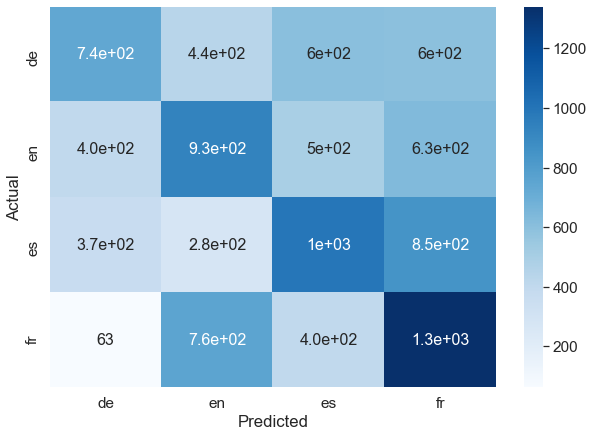

In [31]:
cols = filtered['origin'].cat.categories.values
plot_confusion_matrix(dataset.get_all_labels(), pred, cols)

## Training: Support Vector Machine

In [26]:
y = norm_data['origin']
X = norm_data.loc[:, norm_data.columns != 'origin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train

,T0-T1_en,T1-T2_en,T0-T1_es,T1-T2_es,T0-T1_fr,T1-T2_fr,T0-T1_de,T1-T2_de,src,len
2845,0.925689,0.999975,0.773187,0.999981,0.000000,0.000000,0.909589,0.691154,1.000000,0.120370
21235,0.999500,0.999500,0.999500,0.999500,0.000000,0.000000,0.865451,0.999314,1.000000,0.018519
46320,0.999914,0.999914,0.999946,0.999946,0.000000,0.000000,0.999898,0.999898,1.000000,0.060185
38978,0.842042,0.842897,0.000000,0.000000,0.656119,0.690230,0.570462,0.666933,0.666667,0.055556
3578,0.851282,0.999995,0.786454,0.923397,0.000000,0.000000,0.893846,0.974288,1.000000,0.245370
...,...,...,...,...,...,...,...,...,...,...
11284,0.999979,0.999979,0.973343,0.999986,0.741010,0.999972,0.000000,0.000000,0.000000,0.120370
44732,0.000000,0.000000,0.999977,0.999977,0.901909,0.999983,0.958018,0.999964,0.333333,0.069444
38158,0.828992,0.714593,0.000000,0.000000,0.728211,0.999500,0.821158,0.999500,0.666667,0.013889
860,0.999914,0.999914,0.729950,0.985673,0.000000,0.000000,0.734296,0.999852,1.000000,0.046296


In [17]:
classifier = svm.SVC(probability=True, kernel='poly')
classifier.fit(X_train, y_train)

SVC(kernel='poly', probability=True)

In [18]:
classifier.score(X_test, y_test)

0.40336727492690794

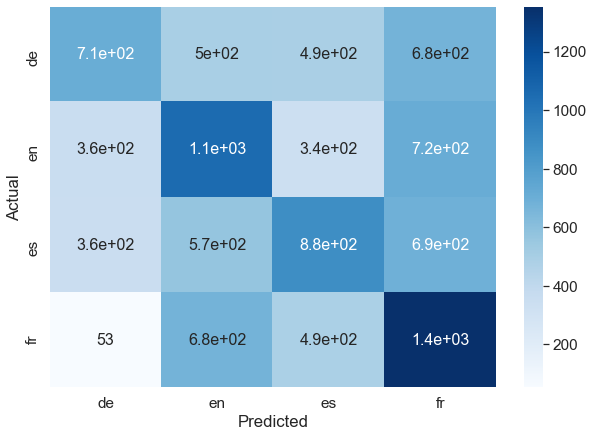

In [19]:
pred = classifier.predict(X_test)
plot_confusion_matrix(y_test.values, pred, filtered['origin'].cat.categories.values)

## Training: Decision Tree

In [28]:
classifier = tree.DecisionTreeClassifier(criterion='entropy')
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [29]:
classifier.score(X_test, y_test)

0.3617300131061599

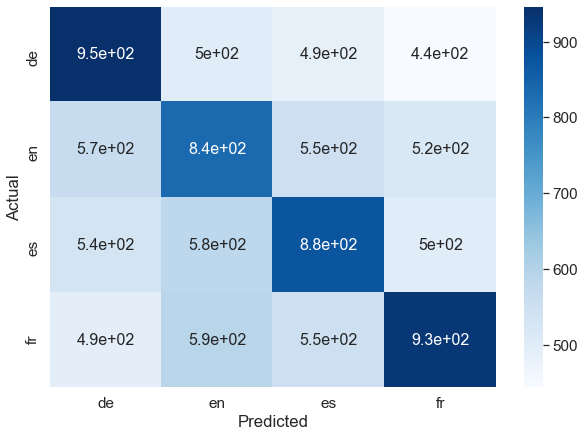

In [30]:
pred = classifier.predict(X_test)
plot_confusion_matrix(y_test.values, pred, filtered['origin'].cat.categories.values)

In [31]:
dot_data = tree.export_graphviz(classifier, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("Tree")

'Tree.pdf'

## Training: KNN

In [23]:
classifier = neighbors.KNeighborsClassifier(n_neighbors=4)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [24]:
classifier.score(X_test, y_test)

0.36122593003326947

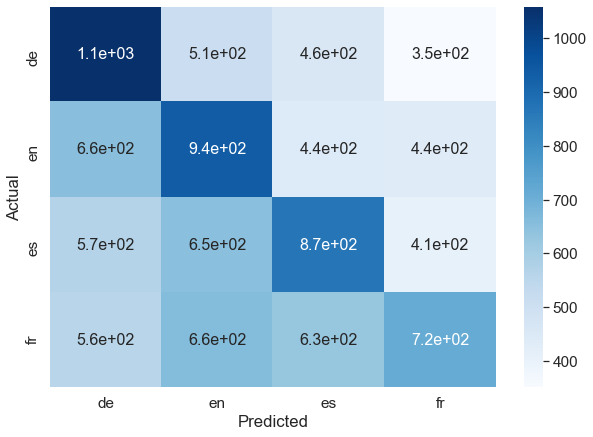

In [25]:
pred = classifier.predict(X_test)
plot_confusion_matrix(y_test.values, pred, filtered['origin'].cat.categories.values)